# COVID-19 country growth analysis


Compares the growth rate of COVID-19 infections within countries.

Important to note:

 - Countries often see a high growth rate in the initial 2-3 weeks due to travellers returning from overseas who (at least in Australia) tend to make up the majority of cases
 - Community transmission is low early and takes hold after this initial 2-3 week period. Countries that are able to slow the community transmission early (by controlling returned travellers through quarantine etc.) have proved most effective in controlling the infection rate
 - It is commonly accepted that infection rates are higher than those reported due to: 
 
  a) lack of availability of testing kits; 
  
  b) strict criteria on who is able to receive a test (due to lack of availability of kits);
  
  c) asymptomatic carriers of the virus (some predictions are around 20%)

In [343]:
# wrangling tools
import numpy as np
import pandas as pd
import datetime as dt
# viz tools
import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [344]:
#import sys
#!{sys.executable} -m pip install plotnine

In [345]:
df_c19_all = pd.read_csv('novel-corona-virus-2019-dataset/covid_19_data.csv')
df_c19_all.tail()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
10041,10042,03/29/2020,Wyoming,US,2020-03-29 23:14:06,86.0,0.0,0.0
10042,10043,03/29/2020,Xinjiang,Mainland China,2020-03-29 23:14:06,76.0,3.0,73.0
10043,10044,03/29/2020,Yukon,Canada,2020-03-29 23:14:06,4.0,0.0,0.0
10044,10045,03/29/2020,Yunnan,Mainland China,2020-03-29 23:14:06,180.0,2.0,172.0
10045,10046,03/29/2020,Zhejiang,Mainland China,2020-03-29 23:14:06,1254.0,1.0,1225.0


In [346]:
# initial cleaning, global variables

df_c19_all['ObservationDate'] = pd.to_datetime(df_c19_all['ObservationDate'])
df_c19_all.rename(columns={'Country/Region':'Country'}, inplace=True)

latest_date = str(dt.date.today() - dt.timedelta(days=2))

## Analysis of growth patterns since 100 cases 
#### For countries > 1,000 cases

In [347]:
def latest_over_thresh(df, num_inf):
    
    '''
    Returns a df with the data for all countries that, as of the latest date in the data,
    have over a certain amount of infections (num_inf)
    '''
    
    latest_date = latest_date = str(dt.date.today() - dt.timedelta(days=2))
    
    df_latest = df[df['ObservationDate'] == latest_date]
    
    country_list = list(df_latest[df_latest['Confirmed'] >= num_inf].Country)
    df_over_thresh = df[df['Country'].isin(country_list)]
    df_over_thresh = df_over_thresh[['ObservationDate','Country','Confirmed','Deaths', 'Recovered']].groupby(['Country', 'ObservationDate']).sum()
    #df_over_thresh.sort_values('Confirmed', ascending=False, inplace=True)
    df_over_thresh.reset_index(inplace=True)
    
    return(df_over_thresh)

In [348]:
df_largest_inf_rates = latest_over_thresh(df_c19_all, 1000)

In [466]:
def days_since_100_cases(df):
    
    '''Take the latest df, filter for days where country has over
    100 cases, then make new field with count since 100 cases'''
    
    
    #df_largest_infRates = latest_over_thresh(df, 1000)
    #df_largest_infRates.sort_values(['Country','ObservationDate'], inplace=True)

    df_100 = df[df['Confirmed'] >= 100]
    df_100 = df_100.sort_values(['Country', 'ObservationDate'], inplace=True)
    df_100['Days_since_100'] = df_100.groupby('Country').cumcount()
    
    return(df_100)

In [467]:
df_since_100 = days_since_100_cases(df_largest_inf_rates)
df_since_100 = df_since_100.reset_index(inplace=True, drop=True)
#df_since_100[df_since_100['Country'] == 'Australia']

/Users/mitchellstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


AttributeError: 'NoneType' object has no attribute 'groupby'

Plot countries' infection growth (where countries currently have over 1000 confirmed cases) from 100 cases onwards

In [351]:
def growth_comparison_lineplot(df, plot_title, label_cond):
    
    p1 = (p9.ggplot(df, p9.aes('Days_since_100', 'Confirmed'))
     + p9.geoms.geom_line(p9.aes(colour='Country'))
     + p9.geoms.geom_text(mapping=p9.aes(label='Country'),
                          data = label_cond,
                         size=7, nudge_y=1)
     + p9.scales.scale_colour_discrete(guide=False)
     + p9.themes.theme_bw()
     + p9.theme(figure_size=(7,5))
     + p9.labels.labs(title = plot_title,
                     x = "Days since 100 cases",
                     y = 'Number of cases')
    )

    return(p1)

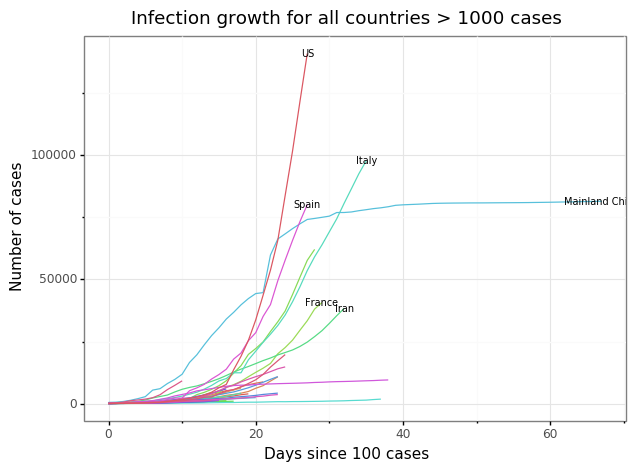

<ggplot: (7553157369)>

In [352]:
line_labels = df_since_100[(df_since_100['ObservationDate']=='2020-03-29') & 
            (df_since_100['Country'].isin(['US', 'Mainland China', 'Italy',
                                'France', 'Spain', 'Iran']))]

growth_comparison_lineplot(df_since_100, 
                           "Infection growth for all countries > 1000 cases",
                          line_labels)

Plot countries who's latest infection number is greater than 10,000

In [353]:
def plot_country_bracket(df, lower_lmt, upper_lmt, title):
    
    df_between = df.groupby('Country').max()
    
    if (lower_lmt > 0 and upper_lmt == 0):
        df_between = df_between[df_between['Confirmed'] >= lower_lmt]
    elif (upper_lmt > 0 and lower_lmt == 0):
        df_between = df_between[df_between['Confirmed'] <= upper_lmt]
    else:
        df_between = df_between[(df_between['Confirmed'] >= lower_lmt) & (df_between['Confirmed'] <= upper_lmt)]    
    
    country_list = list(df_between.index)
    
    df_filtered = df[df['Country'].isin(country_list)]
    
    latest_date = latest_date = str(dt.date.today() - dt.timedelta(days=2))
    line_labels = df_filtered[df_filtered['ObservationDate'] == latest_date]
    growth_plot = growth_comparison_lineplot(df_filtered, 
                                             title,
                                            line_labels)
    
    return(growth_plot)

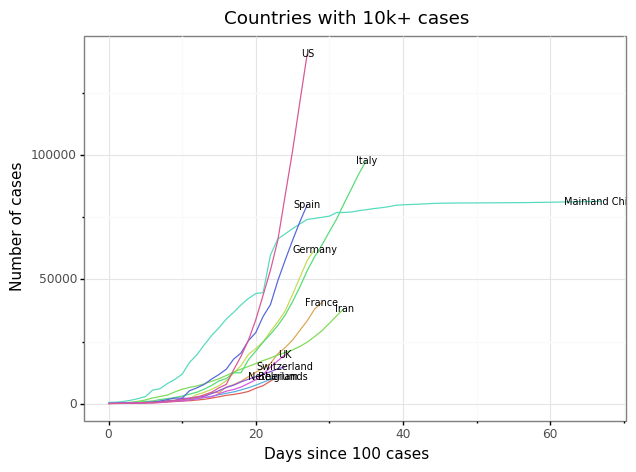

<ggplot: (7554634881)>

In [354]:
plot_country_bracket(df_since_100, 10000, 0, "Countries with 10k+ cases")

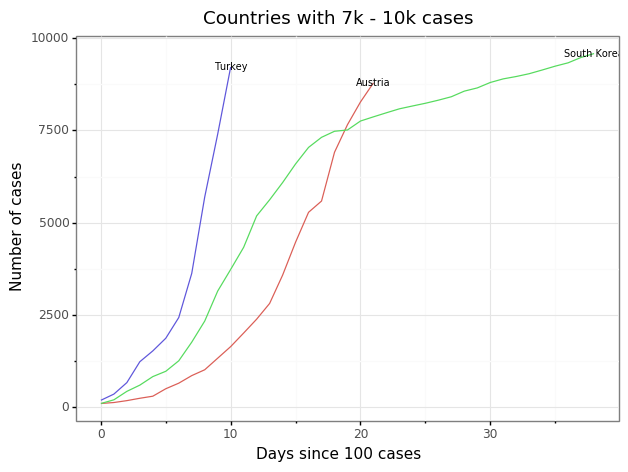

<ggplot: (7553063277)>

In [355]:
plot_country_bracket(df_since_100, 7000, 10000, "Countries with 7k - 10k cases")

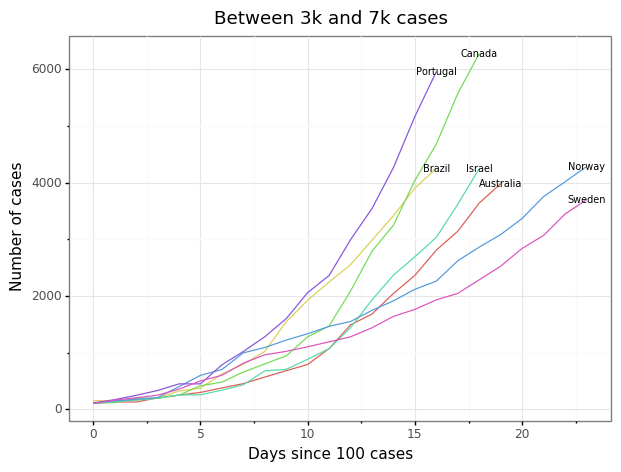

<ggplot: (7553060545)>

In [356]:
plot_country_bracket(df_since_100, 3000, 7000, "Between 3k and 7k cases")

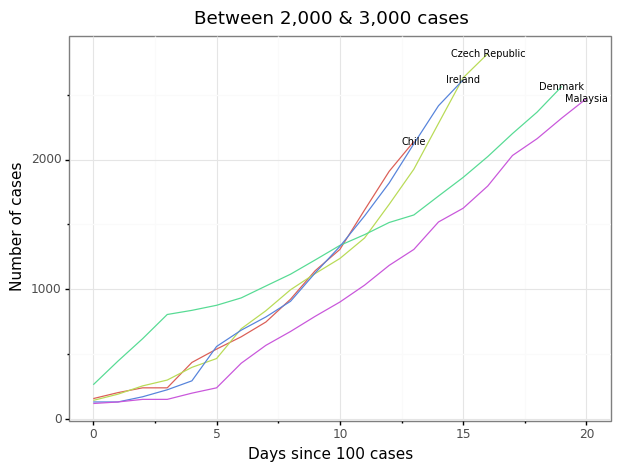

<ggplot: (7553725201)>

In [357]:
plot_country_bracket(df_since_100, 2000, 3000, "Between 2,000 & 3,000 cases")

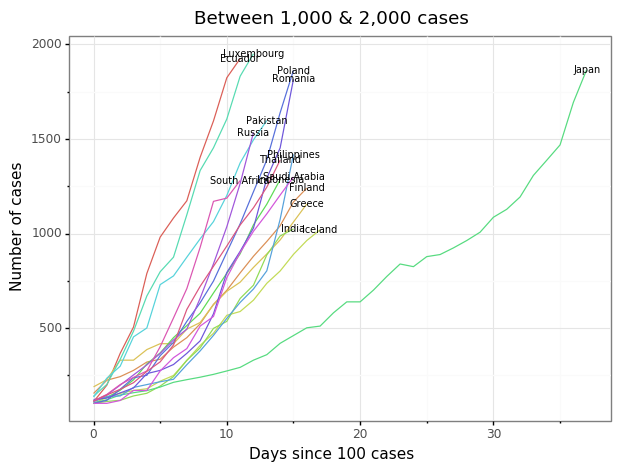

<ggplot: (7553766197)>

In [358]:
plot_country_bracket(df_since_100, 1000, 2000, "Between 1,000 & 2,000 cases")

## Percentage increase analysis

### For countries > 1,000 cases, since first 100 cases

Which countries have had the greatest week-on-week percentage increase in cases (i.e. those countries that are struggling to "flatten the curve")



As there are varying numbers of weeks between countries for days since 100 cases, we will plot four comparison graphs:

 - % increase in first week

 - % increase in second week
 
 - % increase in first two weeks

 - % increase in the previous week from today

In [370]:
def percentage_increase_two_weeks(df):
    
    df_checkpoints = df[(df['Days_since_100'] == 0) |
                            (df['Days_since_100'] == 7) | 
                            (df['Days_since_100'] == 14)]
    df_checkpoints = df_checkpoints.set_index(['Country', 'Days_since_100']).Confirmed
    
    df_grouped_pct_change = pd.DataFrame(df_checkpoints.groupby(['Country']).pct_change())
    df_grouped_pct_change = pd.DataFrame(df_grouped_pct_change.to_records())
    df_grouped_pct_change.fillna(0, inplace=True)    
    
    return(df_grouped_pct_change)

In [373]:
df_first_twoWeeks = percentage_increase_two_weeks(df_since_100)
df_first_twoWeeks = df_first_twoWeeks.rename(columns = {'Confirmed':'Pct_increase'})
df_first_twoWeeks

,Country,Days_since_100,Pct_increase
0,Australia,0,0.000000
1,Australia,7,3.224299
2,Australia,14,3.522124
3,Austria,0,0.000000
4,Austria,7,7.269231
...,...,...,...
114,UK,7,2.991304
115,UK,14,4.917211
116,US,0,0.000000
117,US,7,4.990099


### Trying to make the sort function for the bar chart a re-usable function

In [473]:
def sort_bar_chart(df, col_to_sort_by):
    
    df_sorted = df.sort_values(col_to_sort_by, inplace=True)
    country_list = df_sorted['Country'].to_list()
    countries_sorted = pf.Categorical(df_sorted['Country'],
                                     categories=country_list)
    df_sort_assigned = df_sorted.assign(countries_sorted=countries_sorted)
    
    return(df_sort_assigned)

In [474]:
def plot_one_week_increase(df, days_since_100, week_no):
    
    #Filter and order the df
    df_week = df[df['Days_since_100'] == days_since_100]
    df_week = sort_bar_chart(df_week, 'Pct_increase')
    '''
    df_week = df_week.sort_values('Pct_increase')
    
    country_list = df_week['Country'].to_list()
    country_category = pd.Categorical(df_week['Country'],
                                     categories=country_list)
    
    df_week = df_week.assign(country_category=country_category)
    '''
    
    
    '''Build bar plot'''
    country_week_plot = (p9.ggplot(df_week,
                                   p9.aes(x = 'country_category', y='Pct_increase'))
                         + p9.coords.coord_flip()
                         + p9.geoms.geom_col(stat='identity')
                         + p9.themes.theme_bw()
                         + p9.labels.labs(title = "Percentage increase in cases in {} week".format(week_no),
                                          y = 'Percentage increase')
                        )
    return(country_week_plot)

In [475]:
plot_one_week_increase(df_first_twoWeeks, 7, "first")

/Users/mitchellstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


TypeError: 'NoneType' object is not subscriptable

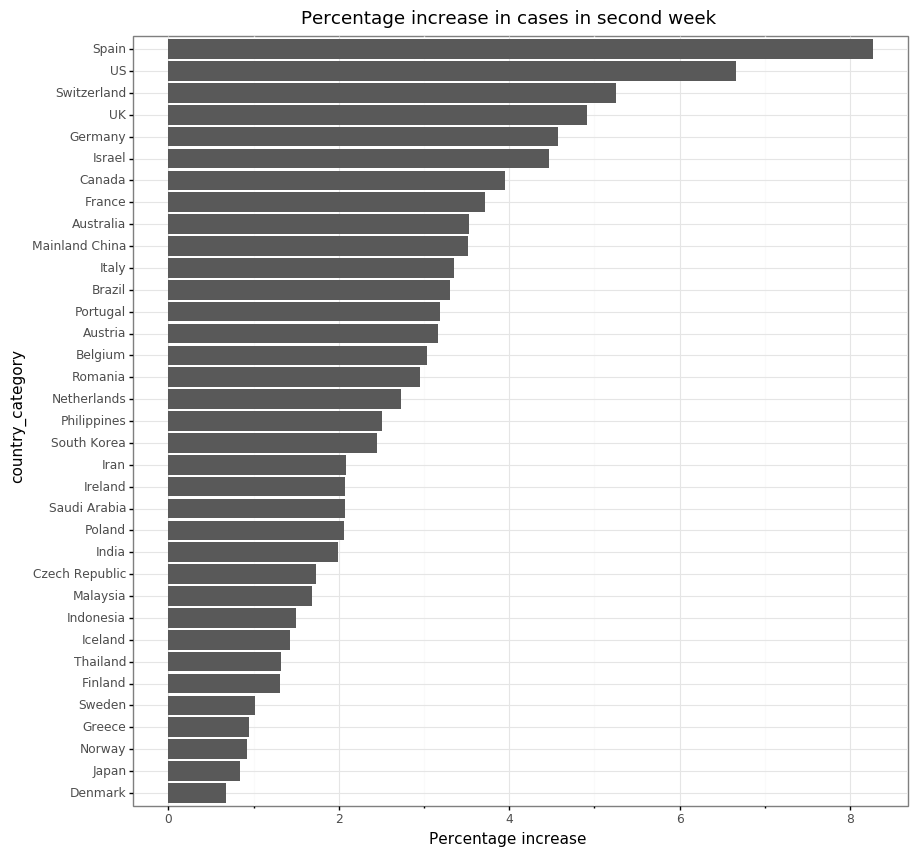

<ggplot: (7551691301)>

In [417]:
plot_one_week_increase(df_first_twoWeeks, 14, "second")

In [424]:
two_weeks_ago = str(dt.date.today() - dt.timedelta(days=16))
two_weeks_ago

'2020-03-15'

In [425]:
df_since_100[(df_since_100['ObservationDate'] == two_weeks_ago)|
            (df_since_100['ObservationDate'] == latest_date)]

df_checkpoints = df_checkpoints.set_index(['Country', 'Days_since_100']).Confirmed
    
    df_grouped_pct_change = pd.DataFrame(df_checkpoints.groupby(['Country']).pct_change())
    df_grouped_pct_change = pd.DataFrame(df_grouped_pct_change.to_records())
    df_grouped_pct_change.fillna(0, inplace=True)

,Country,ObservationDate,Confirmed,Deaths,Recovered,Days_since_100
5,Australia,2020-03-15,297.0,3.0,23.0,5
19,Australia,2020-03-29,3984.0,16.0,244.0,19
27,Austria,2020-03-15,860.0,1.0,6.0,7
41,Austria,2020-03-29,8788.0,86.0,479.0,21
51,Belgium,2020-03-15,886.0,4.0,1.0,9
...,...,...,...,...,...,...
860,Turkey,2020-03-29,9217.0,131.0,105.0,10
871,UK,2020-03-15,1144.0,21.0,19.0,10
885,UK,2020-03-29,19780.0,1231.0,151.0,24
899,US,2020-03-15,3499.0,63.0,12.0,13


In [456]:
def increase_last_two_weeks(df):
    
    df_last_tw = df[(df['ObservationDate'] == two_weeks_ago)|
            (df['ObservationDate'] == latest_date)]
    df_last_tw = df_last_tw.set_index(['Country']).Confirmed
    
    df_last_tw_pc_change = pd.DataFrame(df_last_tw.groupby(['Country']).pct_change())
    df_last_tw_pc_change = pd.DataFrame(df_last_tw_pc_change.to_records())
    df_last_tw_pc_change = df_last_tw_pc_change[df_last_tw_pc_change['Confirmed'].notnull()]
    df_last_tw_pc_change['Pct_increase'] = df_last_tw_pc_change['Confirmed'] * 100
    df_last_tw_pc_change.drop('Confirmed', axis=1, inplace=True)
    
    return(df_last_tw_pc_change)

In [460]:
df_last_two_weeks = increase_last_two_weeks(df_since_100).sort_values('Pct_increase', ascending=False)

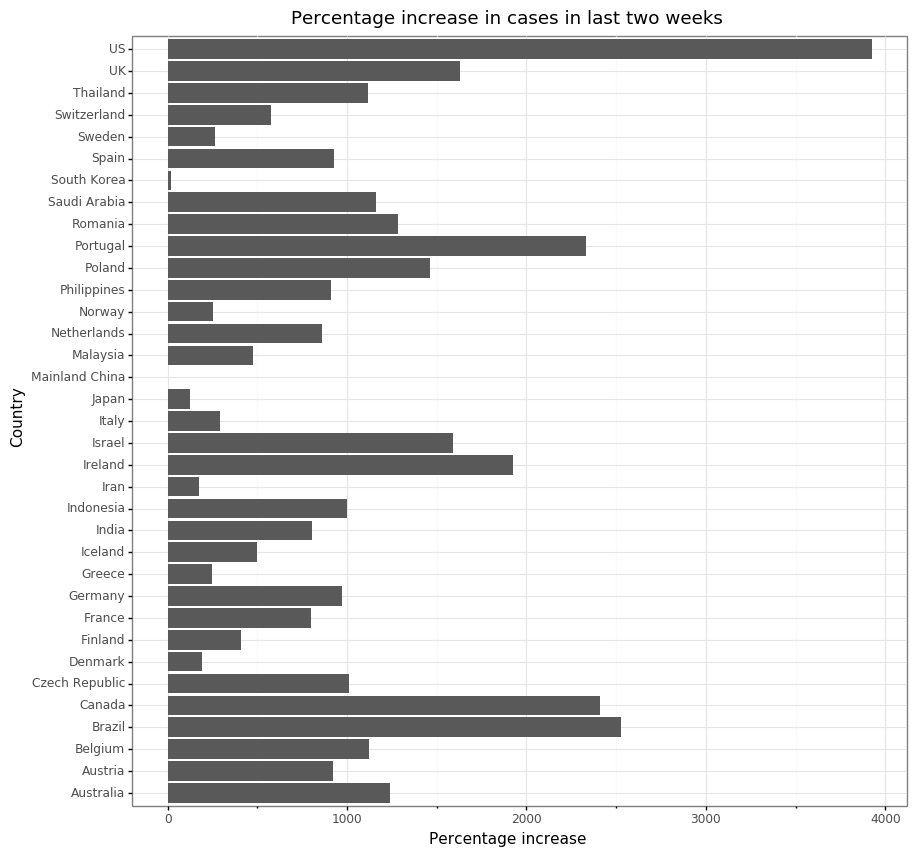

<ggplot: (7549733185)>

In [462]:
(p9.ggplot(df_last_two_weeks,
               p9.aes(x = 'Country', y='Pct_increase'))
     + p9.coords.coord_flip()
     + p9.geoms.geom_col(stat='identity')
     + p9.themes.theme_bw()
     + p9.labels.labs(title = "Percentage increase in cases in last two weeks",
                      y = 'Percentage increase')
    )